In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import gc
import glob
import numba
import numpy.linalg as la
from scipy import stats
from scipy.stats import circmean
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [2]:
foldername = 'ffA3'
n_inds = 10

window_size = '01' # sliding window size in seconds
fps = 10

In [3]:
names = sorted(glob.glob('/media/user/Samsung_T3/Work/Documents/Data/MNagyPigeons/flight_n' + str(n_inds) + '_trajectories/' + foldername + '/' + foldername + '_p*.csv'))

#### Get all pairwise data available from the trajectory data

In [4]:
for i,name in enumerate(names):
    f = pd.read_csv(name)
    
    if len(f.loc[f['GPS_signal'] != 1,:]) == 0:
        if i == 0:
            tmin = np.min(f['#t(centisec)'])

        assert(np.min(f['#t(centisec)']) == tmin)

        f = f.loc[:, ['#t(centisec)', 'X(m)', 'Y(m)', 'dX/dt(m/s)', 'dY/dt(m/s)', 'd^2X/dt^2(m/s^2)', 'd^2Y/dt^2(m/s^2)']]
        f['speed'] = np.sqrt(f['dX/dt(m/s)']**2 + f['dY/dt(m/s)']**2)
        f['acceleration'] = np.sqrt(f['d^2X/dt^2(m/s^2)']**2 + f['d^2Y/dt^2(m/s^2)']**2)

        f['dir_x'] = f['dX/dt(m/s)'] / f['speed']
        f['dir_y'] = f['dY/dt(m/s)'] / f['speed']

        f['f_id'] = i
        f['#t(centisec)'] -= tmin
        f['#t(centisec)'] /= 10

        if i != 0:
            df = pd.concat((df, f), axis=0)
        else:
            df = f
        
df.head()

,#t(centisec),X(m),Y(m),dX/dt(m/s),dY/dt(m/s),d^2X/dt^2(m/s^2),d^2Y/dt^2(m/s^2),speed,acceleration,dir_x,dir_y,f_id
0,0.0,-6.5595,2.7071,0.0220,-0.1079,0.0140,-0.0189,0.110120,0.023520,0.199782,-0.979840,0
1,1.0,-6.5572,2.6963,0.0228,-0.1090,0.0030,-0.0034,0.111359,0.004534,0.204743,-0.978816,0
2,2.0,-6.5549,2.6853,0.0227,-0.1088,-0.0059,0.0097,0.111143,0.011353,0.204242,-0.978920,0
3,3.0,-6.5527,2.6745,0.0218,-0.1075,-0.0119,0.0174,0.109688,0.021080,0.198745,-0.980051,0
4,4.0,-6.5505,2.6638,0.0204,-0.1059,-0.0175,0.0166,0.107847,0.024121,0.189157,-0.981947,0


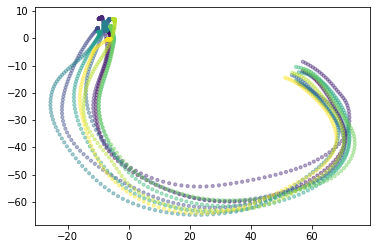

In [5]:
df_plot = df[df['#t(centisec)'] < 200]

plt.scatter(df_plot['X(m)'], df_plot['Y(m)'], c=df_plot['f_id'].values, s=10, alpha=0.4)
plt.show()

In [6]:
n_df = df.loc[:,['#t(centisec)', 'f_id', 'X(m)', 'Y(m)', 'speed', 'acceleration']]
n_df = n_df.rename(index=str, columns={'#t(centisec)':'#t(centisec)', 'f_id':'n_id', 'X(m)':'npos_x', 'Y(m)':'npos_y', 'speed':'n_speed', 'acceleration':'n_acceleration'})

df = pd.merge(df,n_df)

del n_df
gc.collect()

2467

In [7]:
df['speed_diff'] = df['n_speed'] - df['speed']
df['acc_diff'] = df['n_acceleration'] - df['acceleration']

In [8]:
tmp = df.loc[:,["#t(centisec)", "speed", "acceleration"]]

tmp_ord = tmp.groupby(['#t(centisec)']).median()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'speed':'gspeed', 'acceleration':'gacc'})

df = pd.merge(df, tmp_ord, how='left')

df['dev_gspeed'] = df['speed'] - df['gspeed']
df['dev_ngspeed'] = df['n_speed'] - df['gspeed']
df['dev_gacc'] = df['acceleration'] - df['gacc']
df['dev_ngacc'] = df['n_acceleration'] - df['gacc']

In [9]:
tmp = df.loc[:,["#t(centisec)", "X(m)", "Y(m)", "dir_x", "dir_y"]]

tmp_ord = tmp.groupby(['#t(centisec)']).mean()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'X(m)':'centroid_x', 'Y(m)':'centroid_y', 'dir_x':'gdir_x', 'dir_y':'gdir_y'})

df = pd.merge(df, tmp_ord, how='left')
df.head()

,#t(centisec),X(m),Y(m),dX/dt(m/s),dY/dt(m/s),d^2X/dt^2(m/s^2),d^2Y/dt^2(m/s^2),speed,acceleration,dir_x,...,gspeed,gacc,dev_gspeed,dev_ngspeed,dev_gacc,dev_ngacc,centroid_x,centroid_y,gdir_x,gdir_y
0,0.0,-6.5595,2.7071,0.022,-0.1079,0.014,-0.0189,0.11012,0.02352,0.199782,...,0.110964,0.048156,-0.000844,-0.000844,-0.024635,-0.024635,-7.11963,3.89458,-0.141936,0.291119
1,0.0,-6.5595,2.7071,0.022,-0.1079,0.014,-0.0189,0.11012,0.02352,0.199782,...,0.110964,0.048156,-0.000844,0.051247,-0.024635,-0.028022,-7.11963,3.89458,-0.141936,0.291119
2,0.0,-6.5595,2.7071,0.022,-0.1079,0.014,-0.0189,0.11012,0.02352,0.199782,...,0.110964,0.048156,-0.000844,0.000844,-0.024635,-0.030987,-7.11963,3.89458,-0.141936,0.291119
3,0.0,-6.5595,2.7071,0.022,-0.1079,0.014,-0.0189,0.11012,0.02352,0.199782,...,0.110964,0.048156,-0.000844,-0.100281,-0.024635,-0.010204,-7.11963,3.89458,-0.141936,0.291119
4,0.0,-6.5595,2.7071,0.022,-0.1079,0.014,-0.0189,0.11012,0.02352,0.199782,...,0.110964,0.048156,-0.000844,0.143722,-0.024635,-0.035976,-7.11963,3.89458,-0.141936,0.291119


In [10]:
df['centred_x'] = df['X(m)'] - df['centroid_x']
df['centred_y'] = df['Y(m)'] - df['centroid_y']
df['rotated_x'] = df['rotated_y'] = 0
df['ang'] = np.arctan2(df['gdir_y'], df['gdir_x'])

@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

In [11]:
xy = df[['centred_x', 'centred_y']].values
angles = df['ang'].values
rmat = np.array([[np.cos(angles), -np.sin(angles)], [np.sin(angles), np.cos(angles)]]).T

df['rotated_x'], df['rotated_y'] = parallel_rotate(xy, rmat).T

In [12]:
cols = ['dX/dt(m/s)', 'dY/dt(m/s)', 'd^2X/dt^2(m/s^2)', 'd^2Y/dt^2(m/s^2)', 'n_speed', 'n_acceleration', 'gspeed', 'gacc', 'gdir_x', 'gdir_y', 'centred_x', 'centred_y', 'ang']
df.drop(cols, axis=1, inplace=True)

gc.collect()

14545

In [13]:
df['npx'] = df['npos_x'] - df['X(m)']
df['npy'] = df['npos_y'] - df['Y(m)']
df['ang'] = np.arctan2(tmp['dir_y'],tmp['dir_x'])

In [14]:
xy = df[['npx', 'npy']].values
angles = df['ang'].values
rmat = np.array([[np.cos(angles), -np.sin(angles)], [np.sin(angles), np.cos(angles)]]).T

df['rel_pos_x'], df['rel_pos_y'] = parallel_rotate(xy, rmat).T

df['dist'] = np.sqrt(df['rel_pos_x']**2 + df['rel_pos_y']**2)
df['ang_pos_x'] = df['rel_pos_x'] / df['dist']
df['ang_pos_y'] = df['rel_pos_y'] / df['dist']

del tmp_ord
gc.collect()

35

In [15]:
cols = ['npx', 'npy', 'npos_x', 'npos_y', 'ang', 'centroid_x', 'centroid_y', 'rel_pos_x', 'rel_pos_y']
df.drop(cols, axis=1, inplace=True)
df.head()

,#t(centisec),X(m),Y(m),speed,acceleration,dir_x,dir_y,f_id,n_id,speed_diff,acc_diff,dev_gspeed,dev_ngspeed,dev_gacc,dev_ngacc,rotated_x,rotated_y,dist,ang_pos_x,ang_pos_y
0,0.0,-6.5595,2.7071,0.11012,0.02352,0.199782,-0.97984,0,0,0.000000,0.000000,-0.000844,-0.000844,-0.024635,-0.024635,-1.312847,0.016925,0.000000,NaN,NaN
1,0.0,-6.5595,2.7071,0.11012,0.02352,0.199782,-0.97984,0,1,0.052091,-0.003386,-0.000844,0.051247,-0.024635,-0.028022,-1.312847,0.016925,5.448008,-0.908097,-0.418760
2,0.0,-6.5595,2.7071,0.11012,0.02352,0.199782,-0.97984,0,2,0.001687,-0.006352,-0.000844,0.000844,-0.024635,-0.030987,-1.312847,0.016925,3.713802,-0.326803,-0.945093
3,0.0,-6.5595,2.7071,0.11012,0.02352,0.199782,-0.97984,0,3,-0.099437,0.014432,-0.000844,-0.100281,-0.024635,-0.010204,-1.312847,0.016925,4.004675,-0.975451,0.220218
4,0.0,-6.5595,2.7071,0.11012,0.02352,0.199782,-0.97984,0,4,0.144566,-0.011341,-0.000844,0.143722,-0.024635,-0.035976,-1.312847,0.016925,0.614437,-0.266292,-0.963892


In [16]:
df.to_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/pigeons/' + str(n_inds) + '_birds/' + foldername + '/' + 'alltracks.csv', mode='w')